In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Average plane Z positions
Z_DC31_X = -(10.3+7.3-1.7-4.7)/4.0
Z_DC31_Y = -(4.3+1.3-7.7-10.7)/4.0
Z_DC32_X = -(4.5+1.5)/2.0
Z_DC32_Y = -(-1.5-4.5)/2.0

# Detector Z positions
Z_DC31 = -271.5 # mm
Z_DC32 = 787.97 # mm
Z_SRPPAC = 0.0 # mm

spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.parquet("run1011_joined.parquet")
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/14 01:30:46 WARN Utils: Your hostname, gpuana02, resolves to a loopback address: 127.0.1.1; using 192.168.1.216 instead (on interface enp4s0)
26/01/14 01:30:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/14 01:30:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/14 01:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/14 01:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/14 01:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
26/01/14 01:30:47 WARN Utils: Se

+---------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+
|hbfNumber|           sr_pos_x|           sr_pos_y|            dc31_x|             dc31_y|              dc32_x|             dc32_y|
+---------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+
| 11654308|  9.730227768421173|-22.207298398017883|-5.637792587280273|-12.096956253051758|  -5.375353813171387| -13.30980110168457|
| 12050728| -5.426801145076752|-2.6301212310791016| 9.578156471252441|  4.140776634216309|  10.439571380615234|  3.980112314224243|
| 11861422|   9.30324187874794|-13.517164528369904|-4.646420478820801| -5.802151203155518|  -5.619002342224121| -9.681412696838379|
| 12056089|  3.949605293571949|-19.678826302289963|0.7247124910354614|  -9.86113166809082|-0.06751969456672668|-11.117478370666504|
| 11534609|-12.323934733867645| -14.02061302959919|13.147634506225586| -6.84

In [2]:
L2X = Z_DC32 - Z_SRPPAC + Z_DC32_X
L2Y = Z_DC32 - Z_SRPPAC + Z_DC32_Y
L1X = Z_DC31 - Z_SRPPAC + Z_DC31_X
L1Y = Z_DC31 - Z_SRPPAC + Z_DC31_Y

df_chk = df.withColumn("interp_mwdc_x", F.expr(f"-(dc31_x * {L2X} - dc32_x * {L1X})/(ABS({L1X}) + ABS({L2X}))")) \
           .withColumn("interp_mwdc_y", F.expr(f"(dc31_y * {L2Y} - dc32_y * {L1Y})/(ABS({L1Y}) + ABS({L2Y}))"))
df_chk.show(5)

+---------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+
|hbfNumber|           sr_pos_x|           sr_pos_y|            dc31_x|             dc31_y|              dc32_x|             dc32_y|      interp_mwdc_x|      interp_mwdc_y|
+---------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+
| 11654308|  9.730227768421173|-22.207298398017883|-5.637792587280273|-12.096956253051758|  -5.375353813171387| -13.30980110168457|  5.569833562916261|-12.404154864253986|
| 12050728| -5.426801145076752|-2.6301212310791016| 9.578156471252441|  4.140776634216309|  10.439571380615234|  3.980112314224243|   -9.8012215157059|  4.100082347534093|
| 11861422|   9.30324187874794|-13.517164528369904|-4.646420478820801| -5.802151203155518|  -5.619002342224121| -9.681412696838379|  4.89827

Statistics:
[[    0.     0.     0.]
 [    0. 67945.   346.]
 [    0. 11422.    84.]]


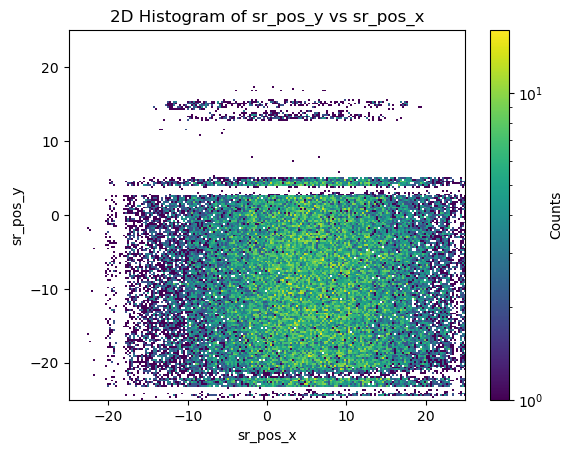

Statistics:
[[0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 7.9009e+04 0.0000e+00]
 [0.0000e+00 1.0000e+00 0.0000e+00]]


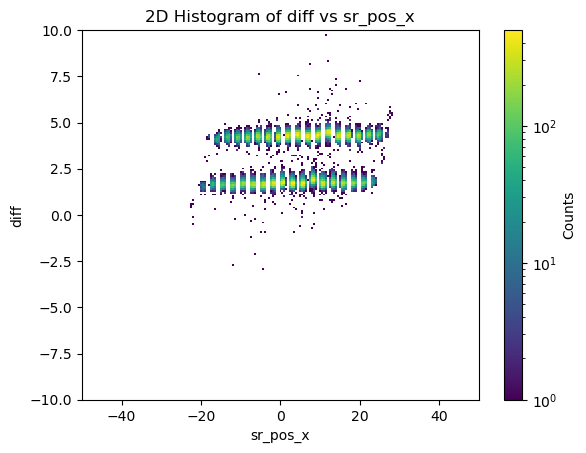

Statistics:
[[    0.     0.     0.]
 [    0. 77568.     0.]
 [    0.    78.     0.]]


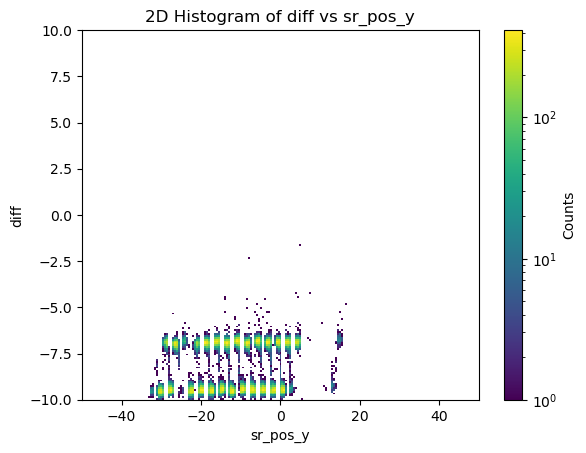

In [3]:
from hist.sparkHist2d import Hist2D
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

h = Hist2D(df_chk, ["sr_pos_x", "sr_pos_y"], [200,200], [[-25,25], [-25,25]], norm=LogNorm(), interpolation='none')
plt.show()
h = Hist2D(df_chk.withColumn("diff", F.expr("sr_pos_x - interp_mwdc_x")), ["sr_pos_x", "diff"], [200,200], [[-50,50], [-10,10]], norm=LogNorm(), interpolation='none')
plt.show()
h = Hist2D(df_chk.withColumn("diff", F.expr("sr_pos_y - interp_mwdc_y")), ["sr_pos_y", "diff"], [200,200], [[-50,50], [-10,10]], norm=LogNorm(), interpolation='none')
plt.show()